In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Acquisition

In this step, Wikipedia traffic data is collected from two different API endpoints. The traffic data is on a monthly basis from December 2007 to September 2021, and it provides page views for different devices. The first API is called Legacy Pagecounts, which provides traffic data with two types of devices from December 2007 to July 2016. The second API is called Pageviews, which provides traffic data with three types of devices from July 2015 up until the project is created (Octorber 2021). The raw data is stored in json formats per its API and device type, so there will be 5 json files generated by the end of this section. 

In [2]:
# prepare to get access to the data from the two API endpoints 
endpoint_pagecounts = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
# specify parameters for getting aggregated legacy view data 
params_pagecounts_desktop = {"project" : "en.wikipedia.org",
                             "access-site" : "desktop-site",
                             "granularity" : "monthly",
                             "start" : "2007120100",
                             "end" : "2016080100"
                                }
params_pagecounts_mobile = {"project" : "en.wikipedia.org",
                             "access-site" : "mobile-site",
                             "granularity" : "monthly",
                             "start" : "2007120100",
                             "end" : "2016080100"
                                }
# specify parameters for getting aggregated current standard pageview data
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                            "access" : "desktop",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : '202110010'
                        }
params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                            "access" : "mobile-web",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : '202110010'
                        }
params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                            "access" : "mobile-app",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : '202110010'
                        }
# specify headers
headers = {
    'User-Agent': 'https://github.com/aixinransummer',
    'From': 'aixinran@uw.edu'
}

In [4]:
# create a function to get data from API endpoints
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [5]:
# get data by calling the above function
monthly_pagecounts_desktop = api_call(endpoint_pagecounts, params_pagecounts_desktop)
monthly_pagecounts_mobile = api_call(endpoint_pagecounts, params_pagecounts_mobile)
monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
monthly_pageviews_mobile_web = api_call(endpoint_pageviews, params_pageviews_mobile_web)
monthly_pageviews_mobile_app = api_call(endpoint_pageviews, params_pageviews_mobile_app)

In [6]:
# save the raw data as json files
with open('pagecounts_desktop-site_200712-201607.json', 'w') as f:
    json.dump(monthly_pagecounts_desktop, f)
with open('pagecounts_mobile-site_200712-201607.json', 'w') as f:
    json.dump(monthly_pagecounts_mobile, f)
with open('pageviews_desktop_201507-202109.json', 'w') as f:
    json.dump(monthly_pageviews_desktop, f)
with open('pageviews_mobile_web_201507-202109.json', 'w') as f:
    json.dump(monthly_pageviews_mobile_web, f)
with open('pageviews_mobile_app_201507-202109.json', 'w') as f:
    json.dump(monthly_pageviews_mobile_app, f)

## Data Processing

In this section, we combine the two mobile-type traffic data from the pageview API together, resulting in four sets of data with two types of API endpoints and two types of devices (desktop and mobile). In addition, year and month information is extracted from the data into separate columns. The sum of views across both types of devices is calculated and included in the cleaned dataset for each API and all NA values will be replaced with 0.  

In [7]:
# create a function to covert dictionaries to dataframes
def convert_dict_to_dataframe(dictionary):
    dictionary_items = dictionary['items']
    dictionary_list = list(dictionary_items)
    df = pd.DataFrame(dictionary_list)
    return df.iloc[:,-2:]

In [8]:
# convert all dictionaries to dataframes by calling the above function
pagecounts_desktop = convert_dict_to_dataframe(monthly_pagecounts_desktop)
pagecounts_mobile = convert_dict_to_dataframe(monthly_pagecounts_mobile)
pageviews_desktop = convert_dict_to_dataframe(monthly_pageviews_desktop)
pageviews_mobile_web = convert_dict_to_dataframe(monthly_pageviews_mobile_web)
pageviews_mobile_app = convert_dict_to_dataframe(monthly_pageviews_mobile_app)

In [9]:
# combine mobile app and mobile web for pageviews
pageviews_mobile = pageviews_mobile_app.merge(pageviews_mobile_web, on='timestamp')
pageviews_mobile['views'] = pageviews_mobile['views_x'] + pageviews_mobile['views_y']
pageviews_mobile = pageviews_mobile[['timestamp','views']]

In [10]:
# rename counts to views to better apply functions later
pagecounts_desktop.rename(columns = {'count':'views'}, inplace=True)
pagecounts_mobile.rename(columns = {'count':'views'}, inplace=True)

In [11]:
# create a function to extract year and month and delete unnecessary columns
def extract_year_and_month(df):
    df['year'] = df['timestamp'].str[:4]
    df['month'] = df['timestamp'].str[4:6]
    return df[['year','month','views']]

In [12]:
# extract year and month for each set of data by calling the above function
pagecounts_desktop_cleaned = extract_year_and_month(pagecounts_desktop)
pagecounts_mobile_cleaned = extract_year_and_month(pagecounts_mobile)
pageviews_desktop_cleaned = extract_year_and_month(pageviews_desktop)
pageviews_mobile_cleaned = extract_year_and_month(pageviews_mobile)

In [23]:
# combine desktop and mobile data for pagecounts API, fill NA with 0
pd.options.display.float_format = '{:.0f}'.format
pagecounts_combined = pagecounts_desktop_cleaned.merge(pagecounts_mobile_cleaned, on=['year','month'], how='left')
pagecounts_combined.rename(columns={'views_x':'pagecount_desktop_views',
                                    'views_y':'pagecount_mobile_views'},inplace=True)
pagecounts_combined.fillna(0, inplace=True)
pagecounts_combined['pagecount_all_views'] = pagecounts_combined['pagecount_desktop_views'] + pagecounts_combined['pagecount_mobile_views']

In [24]:
# combined desktop and mobile data for pageviews API
pageviews_combined = pageviews_desktop_cleaned.merge(pageviews_mobile_cleaned, on=['year','month'])
pageviews_combined.rename(columns={'views_x':'pageview_desktop_views',
                                   'views_y':'pageview_mobile_views'},inplace=True)
pageviews_combined['pageview_all_views'] = pageviews_combined['pageview_desktop_views'] + pageviews_combined['pageview_mobile_views']

In [25]:
# combine pagecounts data and pageview data together, fill NA with 0
data = pagecounts_combined.merge(pageviews_combined, on=['year','month'], how='outer')
data.fillna(0, inplace=True)
data

,year,month,pagecount_desktop_views,pagecount_mobile_views,pagecount_all_views,pageview_desktop_views,pageview_mobile_views,pageview_all_views
0,2007,12,2998331524,0,2998331524,0,0,0
1,2008,01,4930902570,0,4930902570,0,0,0
2,2008,02,4818393763,0,4818393763,0,0,0
3,2008,03,4955405809,0,4955405809,0,0,0
4,2008,04,5159162183,0,5159162183,0,0,0
...,...,...,...,...,...,...,...,...
161,2021,05,0,0,0,2824416177,4976579558,7800995735
162,2021,06,0,0,0,2505971366,4584510417,7090481783
163,2021,07,0,0,0,2765584368,4778909421,7544493789
164,2021,08,0,0,0,2763413934,4732194000,7495607934


In [26]:
# download the dataframe as a csv file
data.to_csv('en-wikipedia_traffic_200712-202109.csv', index=False)

## Data Analysis

For the analysis part, a time series graph will be drawn from the data we cleaned in the previews step. For each API, there are three metrics: monthly views from desktop, monthly views from mobile and monthly views from both devices. 

In [27]:
# define a range of the date for avaliable data
date_range = pd.date_range(start="2007-12-01", end="2021-10-01", freq="M").strftime("%Y-%m")

In [28]:
# specify NA for pageview data so that zeros are not drawn
data_with_na = pagecounts_combined.merge(pageviews_combined, on=['year','month'], how='outer')

Text(0.5, 1.0, 'Monthly Wikipedia Traffic from Two API Endpoints between 2008-2021 ')

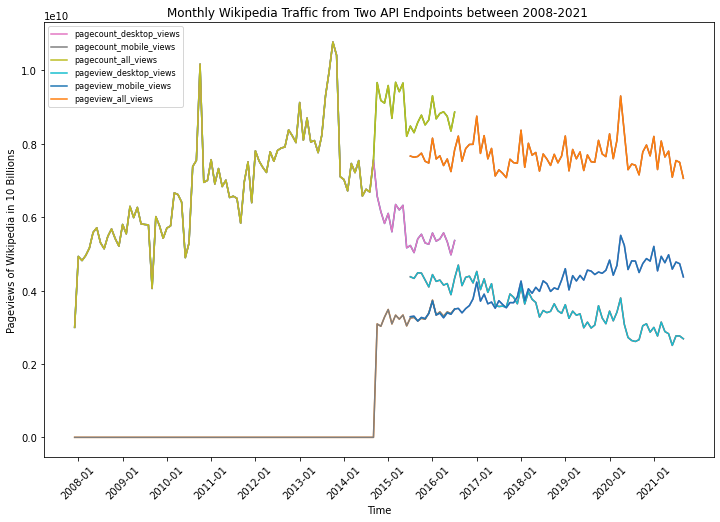

In [29]:
%matplotlib inline
# draw the time series for all six metrics over time
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(date_range, data_with_na.iloc[:,2:])
ax.set_xticks(ax.get_xticks()[1::12])
plt.xticks(rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Pageviews of Wikipedia in 10 Billions")
ax.legend(iter(ax.plot(date_range, data_with_na.iloc[:,2:])), data_with_na.columns[2:], prop={'size': 8})
plt.title('Monthly Wikipedia Traffic from Two API Endpoints between 2008-2021 ')
plt.savefig('time_series.png')